In [1]:
%load_ext autoreload
%autoreload 2
from confignb import *

X, y, pts, ks, masks = util.load_data("data/raw/ASCADv.h5", tgt_only=False)

Wykres outlierów (sigma > 4):

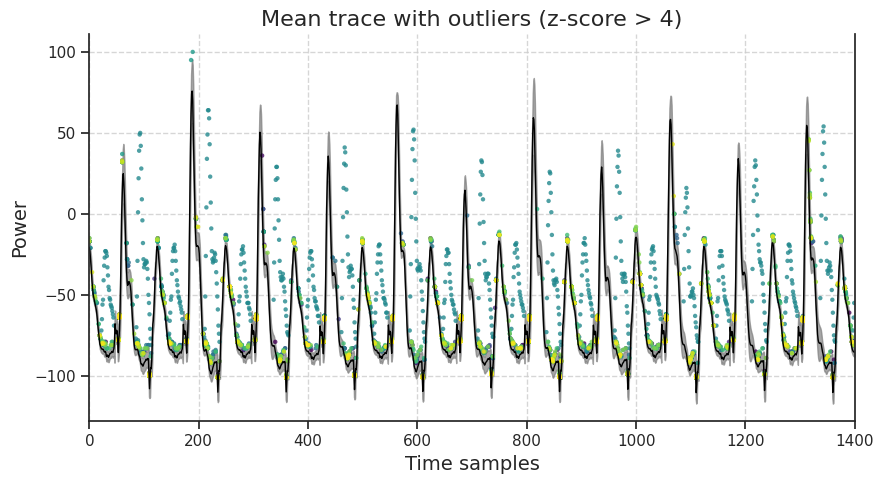

In [ ]:
def plot_trace_outliers(X):
    fig, ax = plt.subplots(figsize=(9, 5))

    plots.plot_mean_std(X, ax=ax)

    ox, oy = np.where((X - X.mean(axis=0)) / X.std(axis=0) > 4)

    cmap = sns.color_palette('viridis', as_cmap=True)
    norm = plt.Normalize(ox.min(), ox.max())
    colors = cmap(norm(ox))

    ax.scatter(oy, X[ox, oy], c=colors, s=10, linewidths=0, alpha=0.8)

    ax.set_xlim(0, X.shape[1])
    plots.labs(ax, xlab="Time samples", ylab="Power",
               title="Mean trace with outliers (z-score > 4)")

    fig.tight_layout()
    sns.despine(ax=ax, right=False)
    return fig, ax

fig, _ = plot_trace_outliers(X)
plots.savetight(fig, "02_outliers.png")

In [5]:
Z = (X - X.mean(axis=0)) / X.std(axis=0)
trace, feat = np.where(Z > 4)

df_z = pd.DataFrame({"Trace": trace, "Feature": feat, "Z-score": Z[trace, feat]})
df_z.sort_values("Z-score", ascending=False, inplace=True)

bins = [4, 5, 7, 10, np.inf]
labels = ["4–5σ", "5–6σ", "7–10σ", ">10σ"]

df_z["Bin"] = pd.cut(df_z["Z-score"], bins=bins, labels=labels, right=True)

df_feat = (df_z
           .groupby(["Trace", "Bin"], observed=False)
           .size()
           .unstack(fill_value=0)
           .reset_index())

df_feat["Total"] = df_feat[labels].sum(axis=1)
df_feat = df_feat.sort_values("Total", ascending=False)
df_feat = df_feat[df_feat["Total"] >= 20]

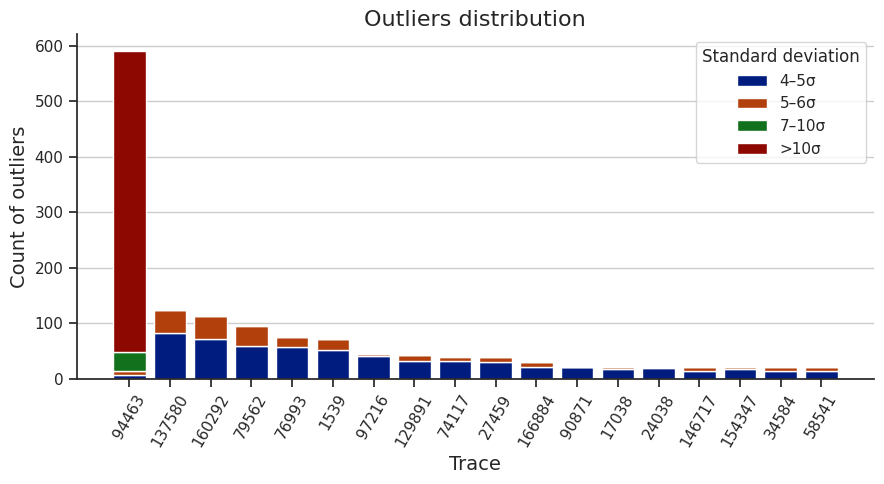

In [7]:
fig, ax = plt.subplots(figsize=(9, 5))

x = np.arange(len(df_feat["Trace"]))
bottom = np.zeros(len(df_feat))

for c in labels:
    ax.bar(x, df_feat[c], bottom=bottom, label=c)
    bottom += df_feat[c].to_numpy()

plots.labs(ax, xlab="Trace", ylab="Count of outliers",
       title="Outliers distribution")
ax.set_xticks(x)
ax.set_xticklabels(df_feat["Trace"], rotation=60)

ax.legend(title="Standard deviation")
ax.grid(axis="y")

sns.despine(ax=ax)
fig.tight_layout()
plots.savetight(fig, "02_outliers_hist.png")

Próbka 94463 jest ewidentnie błędna, więc zostanie usunięta. Pozostałe mimo długich "ogonów" wyglądają sensownie.

In [8]:
util.save_data(
    "data/processed/ASCADv.h5",
    np.delete(X, 94463, axis=0),
    np.delete(y, 94463, axis=0),
    np.delete(pts, 94463, axis=0),
    np.delete(ks, 94463, axis=0),
    np.delete(masks, 94463, axis=0),
)

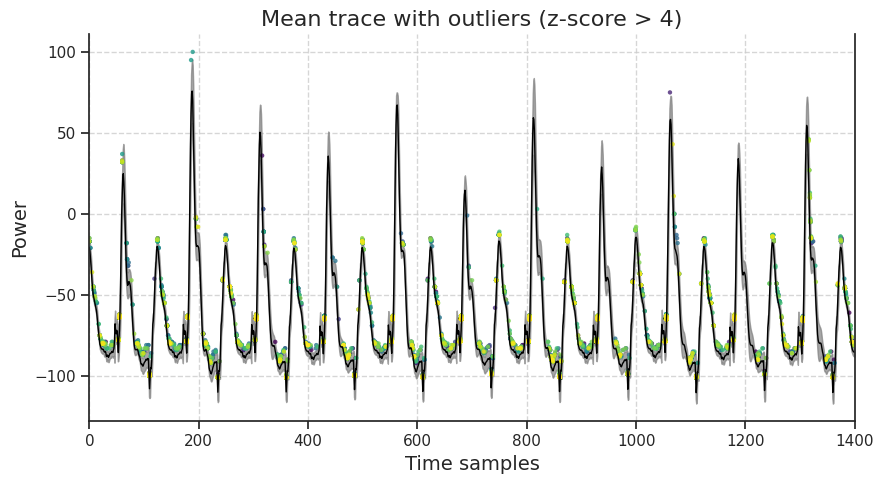

In [9]:
X, y, pts, ks, masks = util.load_data()
fig, _ = plot_trace_outliers(X)
plots.savetight(fig, "02_clean_outliers")